In [43]:
import numpy as np
import tensorflow as tf
import mdn
import time

In [3]:
import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, InputLayer, Attention
from tensorflow.keras.layers import (Conv2D, Input, Reshape, 
                                     Lambda, Dense, Conv2DTranspose)

if tf.test.is_gpu_available():
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
import matplotlib.pyplot as plt
import os
import utils

from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint, 
                                       TensorBoard, Callback)
import datetime
from time import time
from utils import TrainTimeCallback

In [5]:
import matplotlib.pyplot as plt

In [6]:
seq_len = 128
act_len = 3
n_mixtures = 5
output_dims = 32

In [7]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:          24054        3962       15271         246        4820       19450
Swap:           975           0         975


In [8]:
num_instances = len(os.listdir('./sausage/states'))

In [9]:
def load_folder(path):
    files = sorted(os.listdir(path))
    _1 = np.load(os.path.join(path, files[0]))
    data = np.zeros((len(files), *_1.shape))
    for i, fname in enumerate(files):
        data[i] = np.load(os.path.join(path, fname))
    return data

In [10]:
z_states = load_folder('./sausage/z_states')

In [11]:
z_states.shape

(154624, 32)

In [12]:
actions = load_folder('./sausage/actions')

In [13]:
actions.shape

(154624, 3)

In [14]:
154624 / 128 / 128

9.4375

In [15]:
pair = np.concatenate((z_states, actions), axis=1)

In [16]:
pair.shape

(154624, 35)

In [17]:
latent_dataset = tf.data.Dataset.from_tensor_slices(pair)

In [18]:
sequences = latent_dataset.batch(seq_len + 1, drop_remainder=True)

In [19]:
sequences

<BatchDataset shapes: (129, 35), types: tf.float64>

In [20]:
def split_input_target(chunk):
    input_z = chunk[:-1]
    target_z = chunk[1:, :32]
    return input_z, target_z

In [21]:
dataset = sequences.map(split_input_target)

In [22]:
dataset

<MapDataset shapes: ((128, 35), (128, 32)), types: (tf.float64, tf.float64)>

In [23]:
dataset = dataset.shuffle(10000).batch(utils.BATCH_SIZE, drop_remainder=True)

In [24]:
dataset

<BatchDataset shapes: ((128, 128, 35), (128, 128, 32)), types: (tf.float64, tf.float64)>

In [25]:
i = 0
for a, b in dataset:
    i += 1

In [26]:
percent_20 = i // 5
val = dataset.take(percent_20)
train = dataset.skip(percent_20)

In [27]:
val

<TakeDataset shapes: ((128, 128, 35), (128, 128, 32)), types: (tf.float64, tf.float64)>

In [28]:
train

<SkipDataset shapes: ((128, 128, 35), (128, 128, 32)), types: (tf.float64, tf.float64)>

In [29]:
!mkdir "./logs/"
!mkdir "./logs/fit"
!rm "./logs/fit/*"

mkdir: cannot create directory ‘./logs/’: File exists
mkdir: cannot create directory ‘./logs/fit’: File exists
rm: cannot remove './logs/fit/*': No such file or directory


In [30]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [31]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.units = units
        self.W1 = tf.keras.layers.Dense(units, input_shape=(35,))
        self.W2 = tf.keras.layers.Dense(units, input_shape=(256,))
        self.V = tf.keras.layers.Dense(1, input_shape=(256,))

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)
        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        # hidden_with_time_axis = tf.expand_dims(hidden, 1)
        # 
        features = tf.expand_dims(features, 0)
        hidden = tf.expand_dims(hidden, 0)
        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        # context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [32]:
class attention_mdn_rnn(tf.keras.Model):
    def __init__(self, 
                seq_len=128, 
                act_len=3, 
                latent_size=32, 
                cells=256, 
                output_dim=32, 
                n_mixes=5):
        super(attention_mdn_rnn, self).__init__()

        
        self.seq_len=seq_len
        self.act_len=act_len
        self.latent_size=latent_size
        self.cells=cells
        self.output_dim=output_dim
        self.n_mixes=n_mixes
        
        #self.inputs = Input((None, self.act_len + self.latent_size))
        self.lstm   = LSTM(self.cells,
                            return_sequences=True,
                            return_state=True,
                            recurrent_initializer='glorot_uniform')

        self.attention = BahdanauAttention(self.cells)
        self.out       = mdn.MDN(self.output_dim, self.n_mixes)
        
    def call(self, x, hidden):

        context_vector, attention_weights = self.attention(x, hidden)
        #context_vector = context_vector.numpy().squeeze()
        
        # context_vector = features * attention_weights

        x, hidden_out, c = self.lstm(context_vector[0])
        x = self.out(x)
        
        return x, hidden_out#, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.cells))

In [33]:
M = attention_mdn_rnn()

In [34]:
loss_function = mdn.get_mixture_loss_func(32, 5)

In [35]:
optimizer = tf.keras.optimizers.Adam()

In [36]:
loss_plot = []

In [37]:
num_mixes = 5
output_dim = 32

In [38]:
@tf.function
def train_step(pair, target):
    loss = 0
    hidden = M.reset_state(128)

    with tf.GradientTape() as tape:
        z, hidden = M(pair, hidden)
        
        try:
            loss += loss_function(target, z)
        except Exception as e:
            import pdb; pdb.set_trace()
    
    
    total_loss = (loss / int(target.shape[1]))

    trainable_variables = M.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [39]:
start_epoch = 0

In [40]:
tf.keras.backend.set_floatx('float64')

In [41]:
val_loss = []

In [44]:
EPOCHS = 250

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (z_tensor, target)) in enumerate(train):
        batch_loss, t_loss = train_step(z_tensor, target)
        total_loss += t_loss

#         if batch % 5 == 0:
#             print ('Epoch {} Batch {} Loss {:.4f}'.format(
#               epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))

    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / i)

    for (batch, (z_tensor, target)) in enumerate(val):
        batch_loss, t_loss = train_step(z_tensor, target)
        total_loss += t_loss
        
    val_loss.append(total_loss / i)

    # print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
    #                                      total_loss/i))
    # print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended

Epoch 43 Batch 0 Loss 0.2867
Epoch 43 Batch 5 Loss 0.2792
Epoch 43 Loss 0.283064
Time taken for 1 epoch 0.7536652088165283 sec

Epoch 44 Batch 0 Loss 0.2902
Epoch 44 Batch 5 Loss 0.2851
Epoch 44 Loss 0.279022
Time taken for 1 epoch 0.7399618625640869 sec

Epoch 45 Batch 0 Loss 0.2582
Epoch 45 Batch 5 Loss 0.2509
Epoch 45 Loss 0.258065
Time taken for 1 epoch 0.8021576404571533 sec

Epoch 46 Batch 0 Loss 0.2455
Epoch 46 Batch 5 Loss 0.2354
Epoch 46 Loss 0.245696
Time taken for 1 epoch 0.7460074424743652 sec

Epoch 47 Batch 0 Loss 0.2467
Epoch 47 Batch 5 Loss 0.2418
Epoch 47 Loss 0.242881
Time taken for 1 epoch 0.7464311122894287 sec

Epoch 48 Batch 0 Loss 0.2413
Epoch 48 Batch 5 Loss 0.2336
Epoch 48 Loss 0.238718
Time taken for 1 epoch 0.7648787498474121 sec

Epoch 49 Batch 0 Loss 0.2252
Epoch 49 Batch 5 Loss 0.2873
Epoch 49 Loss 0.259165
Time taken for 1 epoch 0.7658452987670898 sec

Epoch 50 Batch 0 Loss 0.2860
Epoch 50 Batch 5 Loss 0.2836
Epoch 50 Loss 0.280877
Time taken for 1 epoch 

Epoch 107 Batch 0 Loss 0.0854
Epoch 107 Batch 5 Loss 0.1576
Epoch 107 Loss 0.131117
Time taken for 1 epoch 0.7605907917022705 sec

Epoch 108 Batch 0 Loss 0.1109
Epoch 108 Batch 5 Loss 0.1189
Epoch 108 Loss 0.119960
Time taken for 1 epoch 0.7537839412689209 sec

Epoch 109 Batch 0 Loss 0.1100
Epoch 109 Batch 5 Loss 0.0956
Epoch 109 Loss 0.118945
Time taken for 1 epoch 0.7441902160644531 sec

Epoch 110 Batch 0 Loss 0.1150
Epoch 110 Batch 5 Loss 0.1240
Epoch 110 Loss 0.115172
Time taken for 1 epoch 0.749103307723999 sec

Epoch 111 Batch 0 Loss 0.1390
Epoch 111 Batch 5 Loss 0.1175
Epoch 111 Loss 0.116340
Time taken for 1 epoch 0.7629404067993164 sec

Epoch 112 Batch 0 Loss 0.0906
Epoch 112 Batch 5 Loss 0.1285
Epoch 112 Loss 0.110118
Time taken for 1 epoch 0.7431700229644775 sec

Epoch 113 Batch 0 Loss 0.1240
Epoch 113 Batch 5 Loss 0.0946
Epoch 113 Loss 0.111768
Time taken for 1 epoch 0.7644236087799072 sec

Epoch 114 Batch 0 Loss 0.1217
Epoch 114 Batch 5 Loss 0.0659
Epoch 114 Loss 0.112745


Epoch 170 Batch 0 Loss 0.1113
Epoch 170 Batch 5 Loss 0.0996
Epoch 170 Loss 0.101015
Time taken for 1 epoch 0.7415192127227783 sec

Epoch 171 Batch 0 Loss 0.0658
Epoch 171 Batch 5 Loss 0.0816
Epoch 171 Loss 0.093272
Time taken for 1 epoch 0.7612249851226807 sec

Epoch 172 Batch 0 Loss 0.0780
Epoch 172 Batch 5 Loss 0.1156
Epoch 172 Loss 0.094800
Time taken for 1 epoch 0.7512238025665283 sec

Epoch 173 Batch 0 Loss 0.0862
Epoch 173 Batch 5 Loss 0.0850
Epoch 173 Loss 0.093088
Time taken for 1 epoch 0.7354331016540527 sec

Epoch 174 Batch 0 Loss 0.1048
Epoch 174 Batch 5 Loss 0.0964
Epoch 174 Loss 0.092444
Time taken for 1 epoch 0.7511420249938965 sec

Epoch 175 Batch 0 Loss 0.1263
Epoch 175 Batch 5 Loss 0.1143
Epoch 175 Loss 0.099859
Time taken for 1 epoch 0.7580201625823975 sec

Epoch 176 Batch 0 Loss 0.1030
Epoch 176 Batch 5 Loss 0.1395
Epoch 176 Loss 0.095304
Time taken for 1 epoch 0.7465894222259521 sec

Epoch 177 Batch 0 Loss 0.1131
Epoch 177 Batch 5 Loss 0.1103
Epoch 177 Loss 0.094972

Epoch 233 Batch 0 Loss 0.1265
Epoch 233 Batch 5 Loss 0.1033
Epoch 233 Loss 0.104461
Time taken for 1 epoch 0.7383244037628174 sec

Epoch 234 Batch 0 Loss 0.1143
Epoch 234 Batch 5 Loss 0.0679
Epoch 234 Loss 0.101813
Time taken for 1 epoch 0.7450954914093018 sec

Epoch 235 Batch 0 Loss 0.0944
Epoch 235 Batch 5 Loss 0.1086
Epoch 235 Loss 0.097414
Time taken for 1 epoch 0.7497951984405518 sec

Epoch 236 Batch 0 Loss 0.1083
Epoch 236 Batch 5 Loss 0.0706
Epoch 236 Loss 0.101293
Time taken for 1 epoch 0.752164363861084 sec

Epoch 237 Batch 0 Loss 0.0990
Epoch 237 Batch 5 Loss 0.0792
Epoch 237 Loss 0.097100
Time taken for 1 epoch 0.7575881481170654 sec

Epoch 238 Batch 0 Loss 0.1254
Epoch 238 Batch 5 Loss 0.1456
Epoch 238 Loss 0.104064
Time taken for 1 epoch 0.7445721626281738 sec

Epoch 239 Batch 0 Loss 0.1049
Epoch 239 Batch 5 Loss 0.1150
Epoch 239 Loss 0.101788
Time taken for 1 epoch 0.7533292770385742 sec

Epoch 240 Batch 0 Loss 0.1201
Epoch 240 Batch 5 Loss 0.0778
Epoch 240 Loss 0.093730


In [47]:
M.save_weights('./data/weights/attn_mdn_rnn.h5') 

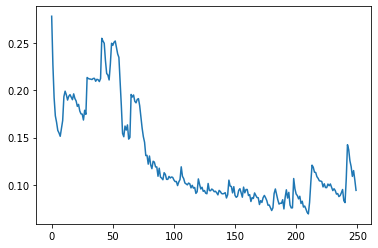

In [48]:
plt.plot(loss_plot)

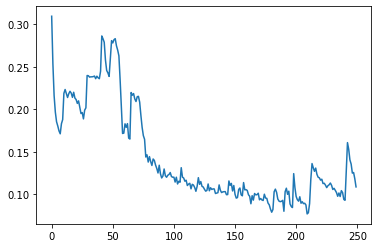

In [49]:
plt.plot(val_loss)